# Halo model power spectra
This example illustrates how to use CCL to calculate power spectra using the halo model.

In [1]:
import sys
sys.path.append('/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/scripts/')
import HSCAnalysisUtils

In [2]:
# Working kernel: desc-python
import numpy as np
import pyccl as ccl
import pylab as plt
import matplotlib.cm as cm
from scipy.special import erf
# %matplotlib inline
import os 
import sacc
import datetime
import time

## Preliminaries
Generate a cosmology object and a couple of $k$ (comoving wavenumber) and $a$ (scale factor) arrays.

In [3]:
# Planck 2018 Cosmology
cosmo = ccl.Cosmology(Omega_c=0.264, Omega_b=0.0493, h=0.6736, sigma8=0.8111, n_s=0.9649)

# Wavenumbers and scale factors
k_arr = np.geomspace(1E-4,1E1,256)
a_arr = np.linspace(0.1,1,64)

Let us also initialize a series of halo model quantities. We will need:
- A halo mass definition.
- A concentration-mass relation.
- A halo mass function parametrization.
- A halo bias parametrization.
- Halo profiles corresponding to the quantities we want to compute the power spectrum of.

In [4]:
# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m()

# The Duffy 2008 concentration-mass relation (Checked - used in paper)
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# The Tinker 2008 mass function (Checked - used in paper)
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200m)

# # The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)

Additionally, in order to showcase the flexibility of the current halo model implementation, let us create our own halo profile characterizing the galaxy overdensity using a Halo Occupation Distribution model. We will use the same parametrization used in Nicola et al. https://arxiv.org/abs/1912.08209.

In [5]:
pg = HSCAnalysisUtils.HaloProfileHOD(cM)

## Halo model power spectra

The halo-model power spectrum for two quantities defined by their halo profiles $u$ and $v$ is given by
\begin{equation}
   P_{uv}(k) = \int dM\,n(M)\,\langle u(k|M)\,v(k|M)\rangle + \left[\int dM\,n(M)\,b(M)\,\langle u(k|M)\rangle\right]\,\left[\int dM\,n(M)\,b(M)\,\langle v(k|M)\rangle\right]\,P_{\rm lin}(k).
\end{equation}

The first part, the so-called "one-halo" term, involves the Fourier-space two-point cumulant of the two profiles ($\langle u(k|M)\,v(k|M)\rangle$). This is often approximated by the product of the profile means ($\langle u(k|M)\rangle\,\langle v(k|M)\rangle$), but this is not correct in general (e.g. for the HOD profile). For this reason, the computation of the halo model power spectrum in CCL requires three main ingredients:
- The two profiles to be correlated.
- The linear matter power spectrum. Together with the profile means it controls the 2-halo term.
- The two-point cumulant of the two profiles, controlling the 1-halo term. By default we will set this to the product of the profile means, but we provide ways to define your own two-points.

Let's start by computing the different auto- and cross-correlations between matter and galaxy overdensities at $z=0$.

The first step is creating a `HMCalculator` object that essentially takes care of the mass integrals.

In [6]:
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200m)

Now let's start computing the different power spectra. Note that, because we are interested in overdensities, we normalize by the means of both quantities. This is done by setting the `normprof` parameters of all method calls to `True`.

### 1. Matter-matter

In [7]:
pk_MM = ccl.halos.halomod_power_spectrum(cosmo, 
                                         hmc,
                                         k_arr,
                                         1.,
                                         pM,
                                         normprof1=True)

### 2. Galaxy-matter

In [8]:
pk_gM = ccl.halos.halomod_power_spectrum(cosmo = cosmo,
                                         hmc = hmc,
                                         k = k_arr,
                                         a = 1.,
                                         prof = pg,
                                         prof2 = pM,
                                         normprof1 = True,
                                         normprof2 = True)

### 3. Galaxy-galaxy

In this case we have a non-trivial two-point cumulant (see Eq. 3.9 of https://arxiv.org/abs/1909.09102). To deal with this we first create a `ProfileCovar` object that implements this.

In [9]:
HOD2pt = HSCAnalysisUtils.Profile2ptHOD()
    
pk_gg = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, 1.,
                                         pg, prof_2pt=HOD2pt,
                                         normprof1=True)

OK, great, now let's plot the power spectra!

In [10]:
%matplotlib inline

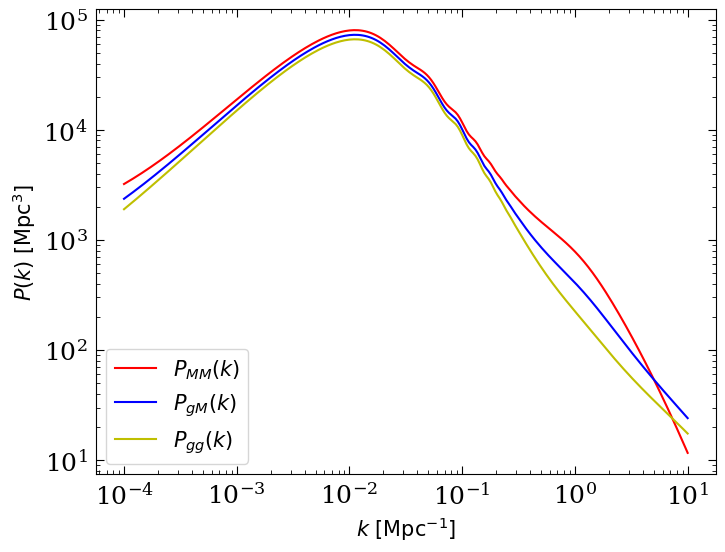

In [11]:
plt.figure()
plt.plot(k_arr, pk_MM, 'r-', label='$P_{MM}(k)$')
plt.plot(k_arr, pk_gM, 'b-', label='$P_{gM}(k)$')
plt.plot(k_arr, pk_gg, 'y-', label='$P_{gg}(k)$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^3]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15)

plt.show()
plt.close()

## 2D power spectra and $C_\ell$s

The `HMCalculator` objects can also provide `Pk2D` power spectrum objects that can then be used to perform Limber integrals and compute angular power spectra. Let's do so for the 3D cross correlations we just looked at.

First, let's create two CCL tracers, a `NumberCountsTracer` that we will associate with the galaxy overdensity, and a `WeakLensing` tracer that we will associate with the matter overdensity.

Here we read the redshift distribution of the lens galaxy sample, similar to the one used in the galaxy clustering analysis presented in Nicola et al.

In [12]:
pk_ggf = ccl.halos.halomod_Pk2D(cosmo,
                                hmc,
                                pg,
                                prof_2pt=HOD2pt,
                                normprof1=True,
                                lk_arr=np.log(k_arr),
                                a_arr=a_arr)

# Save into a data-vector
Put this auto- and cross- correlations of the galaxy clustering in a Firecrown readable format.

Mimicking the sacc file generation process in https://github.com/LSSTDESC/sacc/blob/master/examples/Create_Sacc.ipynb

Adding lens dndz z-bin 1 ...
Adding lens dndz z-bin 2 ...
Adding lens dndz z-bin 3 ...
Adding lens dndz z-bin 4 ...


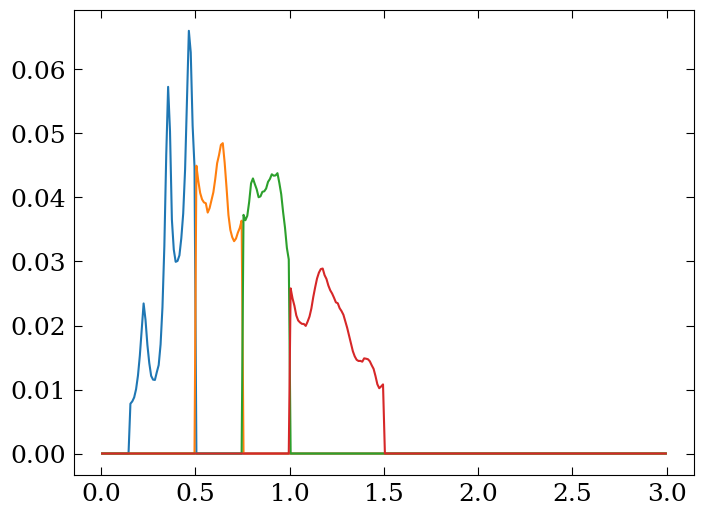

>> Covariance matrix shape BEFORE removing GGL and Shear
(294, 294)
>> Covariance matrix shape AFTER removing GGL and Shear
(90, 90)
>> Length of the signal:  90
>> Introducing covariance matrix



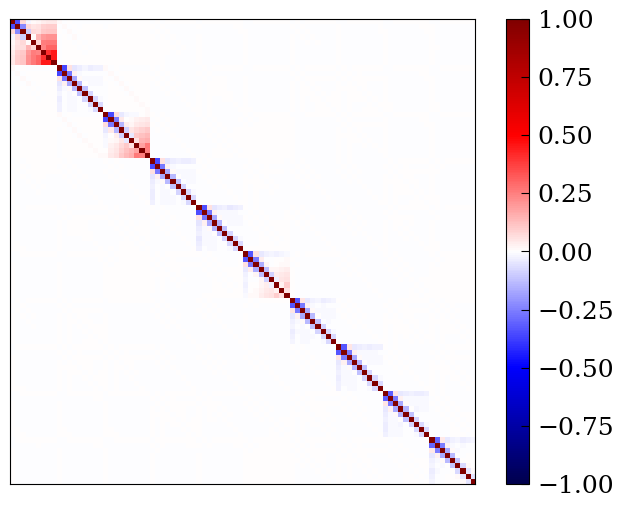

Z-BIN COMBINATION 0 0
z-bin = (0, 0), z_eff = 0.375
Comoving distance = 1517.57 Mpc
Z-BIN COMBINATION 1 0
z-bin = (1, 0), z_eff = 0.498
Comoving distance = 1947.98 Mpc
Z-BIN COMBINATION 1 1
z-bin = (1, 1), z_eff = 0.621
Comoving distance = 2347.52 Mpc
Z-BIN COMBINATION 2 0
z-bin = (2, 0), z_eff = 0.625
Comoving distance = 2357.73 Mpc
Z-BIN COMBINATION 2 1
z-bin = (2, 1), z_eff = 0.747
Comoving distance = 2727.64 Mpc
Z-BIN COMBINATION 2 2
z-bin = (2, 2), z_eff = 0.874
Comoving distance = 3079.67 Mpc
Z-BIN COMBINATION 3 0
z-bin = (3, 0), z_eff = 0.798
Comoving distance = 2871.01 Mpc
Z-BIN COMBINATION 3 1
z-bin = (3, 1), z_eff = 0.921
Comoving distance = 3204.0 Mpc
Z-BIN COMBINATION 3 2
z-bin = (3, 2), z_eff = 1.047
Comoving distance = 3521.38 Mpc
Z-BIN COMBINATION 3 3
z-bin = (3, 3), z_eff = 1.22
Comoving distance = 3920.63 Mpc


In [13]:
s = HSCAnalysisUtils.GenerateHODClustering(cosmo = cosmo,
                                           pk_ggf = pk_ggf,
                                           apply_scalecuts=False)

In [14]:
import HSCMeasurementUtils

In [15]:
fname = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/harmonic/hod_clustering/summary_statistics_clustering_hod_rsd.fits'
labels = 'HOD Clustering'

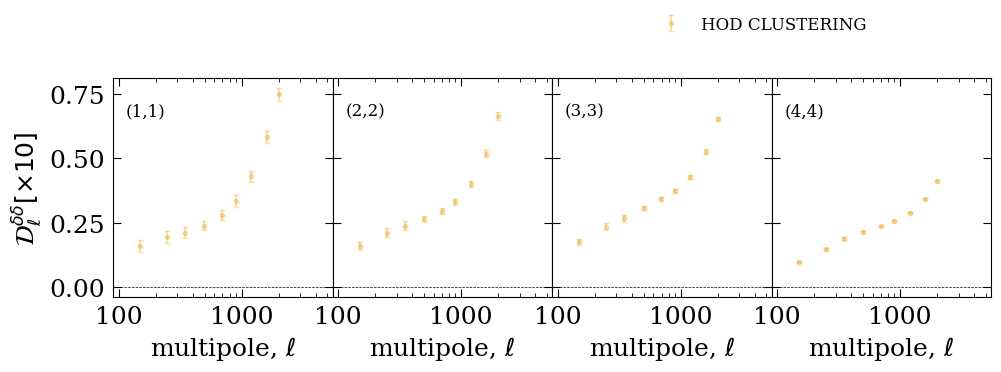

()

In [16]:
HSCMeasurementUtils.Clustering2pt_plot(fname = [fname],
                                       labels = [labels], 
                                       add_individual=True,
                                       add_combined=False,
                                       add_literature=False,
                                       save_fig=False)

# Generate dv with scale cuts

In [17]:
# Planck 2018 Cosmology
cosmo = ccl.Cosmology(Omega_c=0.264, Omega_b=0.0493, h=0.6736, sigma8=0.8111, n_s=0.9649)

In [18]:
fname = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/harmonic/hod_clustering/summary_statistics_clustering_hod_rsd.fits'
s = sacc.Sacc.load_fits(fname) 

Adding lens dndz z-bin 1 ...
Adding lens dndz z-bin 2 ...
Adding lens dndz z-bin 3 ...
Adding lens dndz z-bin 4 ...


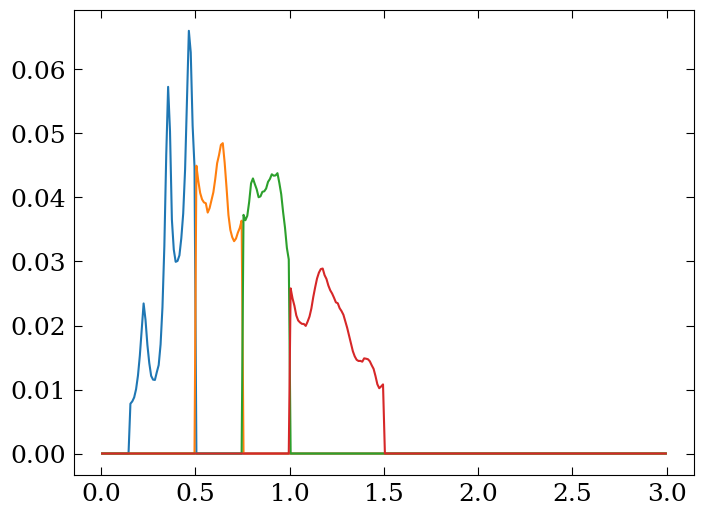

>> Covariance matrix shape BEFORE removing GGL and Shear
(294, 294)
>> Covariance matrix shape AFTER removing GGL and Shear
(90, 90)
>> Length of the signal:  90
>> Introducing covariance matrix



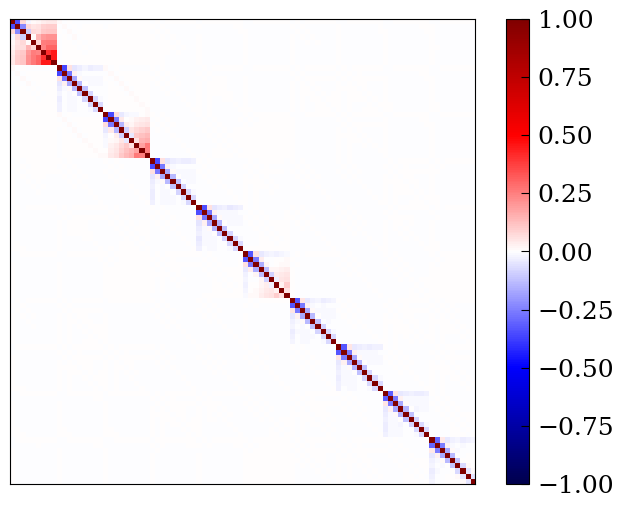

Z-BIN COMBINATION 0 0
z-bin = (0, 0), z_eff = 0.375
Comoving distance = 1517.57 Mpc
Z-BIN COMBINATION 1 0
z-bin = (1, 0), z_eff = 0.498
Comoving distance = 1947.98 Mpc
Z-BIN COMBINATION 1 1
z-bin = (1, 1), z_eff = 0.621
Comoving distance = 2347.52 Mpc
Z-BIN COMBINATION 2 0
z-bin = (2, 0), z_eff = 0.625
Comoving distance = 2357.73 Mpc
Z-BIN COMBINATION 2 1
z-bin = (2, 1), z_eff = 0.747
Comoving distance = 2727.64 Mpc
Z-BIN COMBINATION 2 2
z-bin = (2, 2), z_eff = 0.874
Comoving distance = 3079.67 Mpc
Z-BIN COMBINATION 3 0
z-bin = (3, 0), z_eff = 0.798
Comoving distance = 2871.01 Mpc
Z-BIN COMBINATION 3 1
z-bin = (3, 1), z_eff = 0.921
Comoving distance = 3204.0 Mpc
Z-BIN COMBINATION 3 2
z-bin = (3, 2), z_eff = 1.047
Comoving distance = 3521.38 Mpc
Z-BIN COMBINATION 3 3
z-bin = (3, 3), z_eff = 1.22
Comoving distance = 3920.63 Mpc
>> Producing DATA VECTORS with scale cuts
#######################
k_max = 1.5 [1/Mpc]
#######################
Correlation =  0 0
ell_max = 2276
Correlation =  1 0

/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-

#######################
k_max = 0.3 [1/Mpc]
#######################
Correlation =  0 0
ell_max = 455
Correlation =  1 0
ell_max = 584
Correlation =  1 1
ell_max = 704
Correlation =  2 0
ell_max = 707
Correlation =  2 1
ell_max = 818
Correlation =  2 2
ell_max = 923
Correlation =  3 0
ell_max = 861
Correlation =  3 1
ell_max = 961
Correlation =  3 2
ell_max = 1056
Correlation =  3 3
ell_max = 1176
Number of remaining data points:
Corr 00 = 3
Corr 10 = 4
Corr 11 = 5
Corr 20 = 5
Corr 21 = 5
Corr 22 = 6
Corr 30 = 5
Corr 31 = 6
Corr 32 = 6
Corr 33 = 6
>> Saving data vector ...
#######################
k_max = 0.25 [1/Mpc]
#######################
Correlation =  0 0
ell_max = 379
Correlation =  1 0
ell_max = 486
Correlation =  1 1
ell_max = 586
Correlation =  2 0
ell_max = 589
Correlation =  2 1
ell_max = 681
Correlation =  2 2
ell_max = 769
Correlation =  3 0
ell_max = 717
Correlation =  3 1
ell_max = 801
Correlation =  3 2
ell_max = 880
Correlation =  3 3
ell_max = 980
Number of remaining da

/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-

In [19]:
S = HSCAnalysisUtils.GenerateHODClustering(cosmo = cosmo,
                                           pk_ggf = pk_ggf,
                                           apply_scalecuts=True)